In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [15]:
INPUT_FILE = 'twitter-airline-sentiment/Tweets.csv'
MODEL_PATH = 'model2'

raw_data = pd.read_csv(INPUT_FILE, header=0)
df = raw_data.copy()[['text', 'airline_sentiment']]
df = df.rename(columns={'airline_sentiment': 'sentiment'})
df_labeled = df[df.sentiment != 'neutral']

print("DATA SIZE: " + str(df.shape))
df.head()

DATA SIZE: (14640, 2)


,text,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [41]:
def remove_first_handler(text):
    parts = text.strip().split(' ', 1)
    if len(parts) == 2 and parts[0].startswith('@'):
        return parts[1].strip()
    else:
        return text

df['text'] = df['text'].apply(remove_first_handler)
df_labeled = df[df.sentiment != 'neutral']

df.head()

,text,sentiment
0,What @dhepburn said.,neutral
1,plus you've added commercials to the experienc...,positive
2,I didn't today... Must mean I need to take ano...,neutral
3,"it's really aggressive to blast obnoxious ""ent...",negative
4,and it's a really big bad thing about it,negative


In [17]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.1, random_state=0)

print("Training: %d; test: %d" % (len(train_df), len(valid_df)))

Training: 13176; test: 1464


In [18]:
train_df.head()

,text,sentiment
5909,Thank you. Great tool,positive
13662,working over time tonight? Got delayed 2 days...,negative
12405,Delayed: AA3186 - Missed due to delay: AA3186 ...,negative
2528,while busy on his cell phone ???,negative
2043,you hung up on me again.,negative


In [19]:
data_lm = TextLMDataBunch.from_df(MODEL_PATH, train_df=train_df, valid_df=valid_df, text_cols='text')

In [20]:
data_lm.show_batch()

idx,text
0,again . xxbos you left my bag in xxmaj houston last night . xxmaj it 's freezing cold in xxmaj memphis . xxmaj any idea on when i will see it ? xxmaj off again tomorrow . xxbos you 're doing a great job adding little luxuries / xxunk that improve the air travel experience . xxmaj thank you . xxmaj keep it up ! xxbos then this agent xxunk
1,"hassle ; plus no wait on phone & & an upgrade . xxmaj thank you ! xxbos are you hiring for flight attendants right now xxbos my son is flying xxmaj south xxmaj west from xxup nola - xxmaj orlando , hope to enter for him to win this contest # destinationdragons xxbos xxup it xxup has xxup been xxup found xxup thank xxup you xxbos xxunk more money to"
2,"like u expect ur customers to . xxmaj be a competent company like ur xxunk xxbos xxmaj flight 683 last night was # xxunk . xxmaj will be a long time before i recommend xxmaj united to anyone . xxbos xxup clt , please send more than one cust svc rep to your cust svc counter to assist a line out the door . http : / / t.co /"
3,rooms for people claiming weather http : / / t.co / xxunk xxbos @claudoakeshott how about a link that works pls xxmaj nothing but complete frustration w usair last 12 hrs xxbos too xxmaj late xxmaj flight . xxmaj several passengers are xxunk . xxmaj you 're in xxunk with big alcohol . xxmaj shame on you . xxbos xxmaj thank you xxrep 5 . you do the same !
4,put xxbos he is at the xxmaj boston airport . xxmaj there is a problem . xxmaj the agents will not honor the voucher because one number is xxunk out . xxbos - i really down think downgrading the booze / food xxunk at the club is a good way to go . xxmaj how about you look @aircanada ? xxbos xxup dont xxup lose xxup my xxup luggage !


In [22]:
data_lm.save('lm_raw01.pkl')

In [23]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


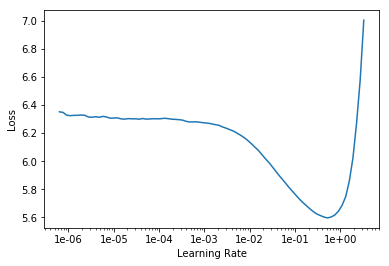

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(4, 0.5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.785325,7.317272,0.134905,00:11
1,6.637125,5.587189,0.181752,00:11
2,5.513689,4.640065,0.219169,00:12
3,4.741753,4.416802,0.237612,00:12


In [27]:
learn.save('fit_head')

In [28]:
learn.load('fit_head');

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(10, 0.05, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.310609,4.295831,0.248549,00:15
1,4.287871,4.266989,0.244169,00:16
2,4.263551,4.214126,0.251172,00:16
3,4.147908,4.137823,0.259654,00:16
4,4.010778,4.099760,0.267020,00:16
5,3.840070,4.064939,0.272684,00:16
6,3.638751,4.058888,0.278878,00:16
7,3.384350,4.100805,0.280106,00:16
8,3.186899,4.197411,0.275000,00:16
9,2.955829,4.243609,0.275084,00:16


In [31]:
learn.save('fine_tuned')

In [32]:
learn.load('fine_tuned');

In [33]:
TEXT = "My flight was"
N_WORDS = 40
N_SENTENCES = 2

In [34]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

My flight was delayed and then the supervisor was n't a long wait . Called to reschedule a flight . Now arriving almost 4 hours on hold . And this has been a problem since AA ! xxbos
My flight was Cancelled Flightled & & i 'm at IAH . Can you help rebook ? xxbos i 'm extremely disappointed with the service today . i would appreciate it . Thank you . xxbos Will


In [35]:
learn.save_encoder('fine_tuned_enc')

### Classifier

In [42]:
def balance_class_counts(df):
    class_counts = df.groupby('sentiment').count()
    min_size = class_counts['text'].min()
    classes = []
    for label in class_counts.index:
        classes.append(df.copy()[df.sentiment == label][:min_size])
    return pd.concat(classes, ignore_index=True).reset_index(drop=True)

train_df_l, valid_df_l = train_test_split(balance_class_counts(df_labeled), test_size=0.1, random_state=0)

print("Training: %d; test: %d" % (len(train_df_l), len(valid_df_l)))

Training: 4253; test: 473


In [43]:
class_counts = train_df_l.groupby('sentiment').count()
class_counts

,text
sentiment,
negative,2123
positive,2130


In [44]:
data_clas = TextClasDataBunch.from_df(MODEL_PATH, train_df=train_df_l, valid_df=valid_df_l, 
                                      text_cols='text', label_cols='sentiment', vocab=data_lm.vocab)

In [45]:
data_clas.show_batch()

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
xxbos - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - xxup sfo # 1589 . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs .,negative
xxbos 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative
xxbos : xxmaj unhappy with xxmaj united 's service ? \n \n xxmaj read xxmaj xxunk xxmaj xxunk 's open letter to xxup ual 's xxup ceo . \n \n xxmaj leave a comment or xxup rt . \n \n http : / / t.co / xxunk,negative


In [46]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


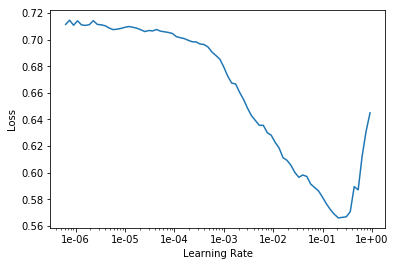

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(1, 0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.712589,0.427694,0.822410,00:02


In [50]:
learn.save('first')

In [51]:
learn.load('first');

In [52]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(0.1/(2.6**4),0.1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.468385,0.319315,0.877378,00:03


In [53]:
learn.save('second')

In [54]:
learn.load('second');

In [55]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.377017,0.298803,0.858351,00:05


In [56]:
learn.save('third')

In [57]:
learn.save('load');

In [58]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.343135,0.299729,0.864693,00:06
1,0.296629,0.292568,0.868922,00:06


In [59]:
learn.predict("Awful flight")

(Category negative, tensor(0), tensor([0.7152, 0.2848]))

In [60]:
learn.predict("Great trip, thanks to all")

(Category positive, tensor(1), tensor([0.0046, 0.9954]))

In [61]:
learn.predict("The attendant was very rude!")

(Category positive, tensor(1), tensor([0.1109, 0.8891]))